In [23]:
import duckdb
import psycopg2
import time
import pandas as pd
import matplotlib.pyplot as plt

# Database connection details
DB_NAME = "oltp_olap"
DB_USER = "rohitagarwal"
DB_PASSWORD = "rohit2610"
DB_HOST = "localhost"  # or an IP address/hostname
DB_PORT = 5432


results = []

conn_oltp = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        host=DB_HOST,
        port=DB_PORT
    )
    
# Create a cursor object
cursor = conn_oltp.cursor()

conn_olap = duckdb.connect(database="warehouse.test_db", read_only=False)

Now, Lets time query execution in both OLTP and OLAP databases.

In [24]:
query = """EXPLAIN ANALYZE
SELECT
    d.name AS department,
    EXTRACT(YEAR FROM p.year_month) AS year,
    SUM(p.net_salary) AS total_payroll
FROM payroll_monthly p
JOIN employee e ON p.employee_id = e.employee_id
JOIN department d ON e.department_id = d.department_id
GROUP BY d.name, year
ORDER BY year, total_payroll DESC;"""

start_time_oltp = time.perf_counter()
output = cursor.execute(query)
end_time_oltp = time.perf_counter()

start_time_olap = time.perf_counter()
output = conn_olap.execute(query)
end_time_olap = time.perf_counter()

results.append({"Query": "Query 1", "Database": "OLAP", "Execution Time (milliseconds)": (end_time_olap - start_time_olap)*1000})
results.append({"Query": "Query 1", "Database": "OLTP", "Execution Time (milliseconds)": (end_time_oltp - start_time_oltp)*1000})

print(f"OLAP Query 1 Execution Time: {(end_time_olap - start_time_olap) * 1000} milliseconds")
print(f"OLTP Query 1 Execution Time: {(end_time_oltp - start_time_oltp) * 1000} milliseconds")

OLAP Query 1 Execution Time: 14.815224974881858 milliseconds
OLTP Query 1 Execution Time: 246.22579698916525 milliseconds


In [25]:
query = """EXPLAIN ANALYZE
SELECT
    d.name AS department,
    COUNT(*) FILTER (WHERE a.status = 'P') * 100.0 / COUNT(*) AS attendance_pct
FROM attendance a
JOIN employee e ON a.employee_id = e.employee_id
JOIN department d ON e.department_id = d.department_id
GROUP BY d.name
ORDER BY attendance_pct DESC;"""

start_time_oltp = time.perf_counter()
output = cursor.execute(query)
end_time_oltp = time.perf_counter()

start_time_olap = time.perf_counter()
output = conn_olap.execute(query)
end_time_olap = time.perf_counter()

results.append({"Query": "Query 2", "Database": "OLAP", "Execution Time (milliseconds)": (end_time_olap - start_time_olap)*1000})
results.append({"Query": "Query 2", "Database": "OLTP", "Execution Time (milliseconds)": (end_time_oltp - start_time_oltp)*1000})

print(f"OLAP Query 2 Execution Time: {(end_time_olap - start_time_olap) * 1000} milliseconds")
print(f"OLTP Query 2 Execution Time: {(end_time_oltp - start_time_oltp) * 1000} milliseconds")

OLAP Query 2 Execution Time: 60.99481298588216 milliseconds
OLTP Query 2 Execution Time: 1801.1700630304404 milliseconds


In [26]:
query = """EXPLAIN ANALYZE
SELECT
    e.employee_id,
    e.full_name,
    SUM(p.net_salary) AS lifetime_salary
FROM payroll_monthly p
JOIN employee e ON p.employee_id = e.employee_id
GROUP BY e.employee_id, e.full_name
ORDER BY lifetime_salary DESC
LIMIT 20;
"""

start_time_oltp = time.perf_counter()
output = cursor.execute(query)
end_time_oltp = time.perf_counter()

start_time_olap = time.perf_counter()
output = conn_olap.execute(query)
end_time_olap = time.perf_counter()

results.append({"Query": "Query 3", "Database": "OLAP", "Execution Time (milliseconds)": (end_time_olap - start_time_olap)*1000})
results.append({"Query": "Query 3", "Database": "OLTP", "Execution Time (milliseconds)": (end_time_oltp - start_time_oltp)*1000})

print(f"OLAP Query 3 Execution Time: {(end_time_olap - start_time_olap) * 1000} milliseconds")
print(f"OLTP Query 3 Execution Time: {(end_time_oltp - start_time_oltp) * 1000} milliseconds")

OLAP Query 3 Execution Time: 18.809324014000595 milliseconds
OLTP Query 3 Execution Time: 274.8875850229524 milliseconds


In [27]:
query = """EXPLAIN ANALYZE
WITH yearly_payroll AS (
    SELECT
        d.name AS department,
        EXTRACT(YEAR FROM p.year_month) AS year,
        SUM(p.net_salary) AS total_payroll
    FROM payroll_monthly p
    JOIN employee e ON p.employee_id = e.employee_id
    JOIN department d ON e.department_id = d.department_id
    GROUP BY d.name, year
)
SELECT
    department,
    year,
    total_payroll,
    total_payroll
        - LAG(total_payroll) OVER (PARTITION BY department ORDER BY year)
        AS yoy_growth
FROM yearly_payroll
ORDER BY department, year;

"""

start_time_oltp = time.perf_counter()
output = cursor.execute(query)
end_time_oltp = time.perf_counter()

start_time_olap = time.perf_counter()
output = conn_olap.execute(query)
end_time_olap = time.perf_counter()

results.append({"Query": "Query 4", "Database": "OLAP", "Execution Time (milliseconds)": (end_time_olap - start_time_olap)*1000})
results.append({"Query": "Query 4", "Database": "OLTP", "Execution Time (milliseconds)": (end_time_oltp - start_time_oltp)*1000})

print(f"OLAP Query 4 Execution Time: {(end_time_olap - start_time_olap) * 1000} milliseconds")
print(f"OLTP Query 4 Execution Time: {(end_time_oltp - start_time_oltp) * 1000} milliseconds")

OLAP Query 4 Execution Time: 21.164864010643214 milliseconds
OLTP Query 4 Execution Time: 136.92122203065082 milliseconds


Analytical queries analysis

In [55]:
time_df = pd.DataFrame(results)
time_grouped_df = time_df.groupby(['Query', 'Database']).mean()
time_grouped_df["Execution Time (milliseconds)"] = time_grouped_df["Execution Time (milliseconds)"].round(2)
time_grouped_df

Execution Time (milliseconds)
Query   Database                               
Query 1 OLAP                              14.82
        OLTP                             246.23
Query 2 OLAP                              60.99
        OLTP                            1801.17
Query 3 OLAP                              18.81
        OLTP                             274.89
Query 4 OLAP                              21.16
        OLTP                             136.92

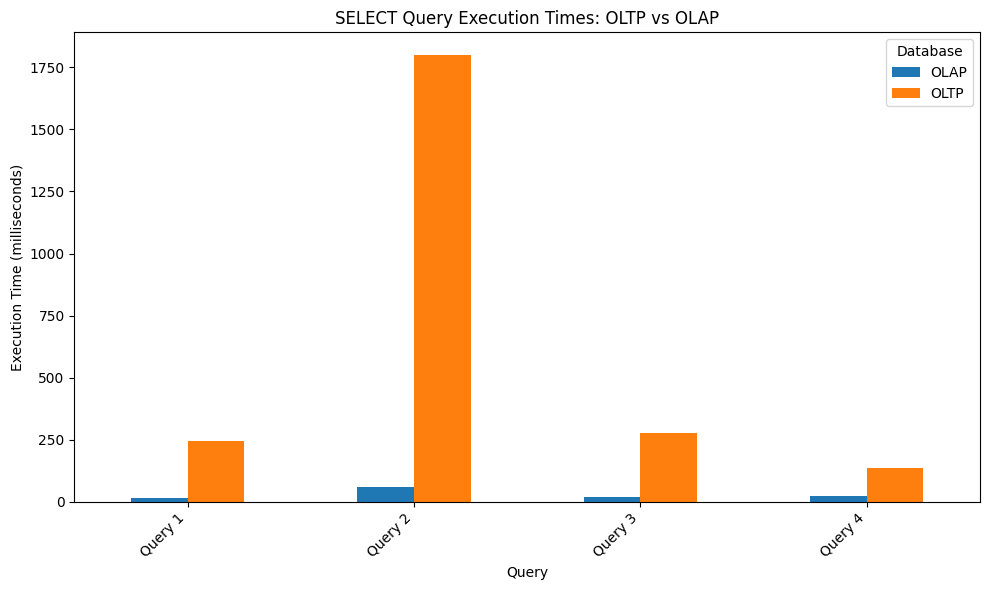

In [29]:
# Plot for SELECT queries
plt.figure(figsize=(10, 6))
time_df.pivot(index='Query', columns='Database', values='Execution Time (milliseconds)').plot(kind='bar', ax=plt.gca())
plt.title('SELECT Query Execution Times: OLTP vs OLAP')
plt.ylabel('Execution Time (milliseconds)')
plt.xlabel('Query')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Database')
plt.tight_layout()
plt.show()

Insertion testing between OLTP and OLAP databases

In [30]:
cursor.execute("DROP TABLE IF EXISTS sample_table;")
conn_olap.execute("DROP TABLE IF EXISTS sample_table;")

In [31]:
cursor.execute("CREATE TABLE IF NOT EXISTS sample_table (id SERIAL, name VARCHAR(100), phone VARCHAR(15), email VARCHAR(100));")

In [32]:
conn_olap.execute("CREATE TABLE IF NOT EXISTS sample_table (id INTEGER, name VARCHAR, phone VARCHAR, email VARCHAR);")

In [36]:
start_time_oltp = time.perf_counter()
for i in range(1, 10001):
    name = f'Name_{i}'
    phone = f'123-456-789{i%10}'
    email = f'name_{i}@example.com'

    cursor.execute("INSERT INTO sample_table (name, phone, email) VALUES (%s, %s, %s);", (name, phone, email))

end_time_oltp = time.perf_counter()

start_time_olap = time.perf_counter()
for i in range(1, 10001):
    name = f'Name_{i}'
    phone = f'123-456-789{i%10}'
    email = f'name_{i}@example.com'

    conn_olap.execute("INSERT INTO sample_table (id, name, phone, email) VALUES (?, ?, ?, ?);", (i, name, phone, email))
end_time_olap = time.perf_counter()


print(f"OLTP Insertion Time for 10,000 records: {(end_time_oltp - start_time_oltp) * 1000} milliseconds")
print(f"OLAP Insertion Time for 10,000 records: {(end_time_olap - start_time_olap) * 1000} milliseconds")

# Create DataFrame for INSERT timing
insert_results = [
    {"Operation": "INSERT", "Database": "OLTP", "Execution Time (milliseconds)": (end_time_oltp - start_time_oltp) * 1000},
    {"Operation": "INSERT", "Database": "OLAP", "Execution Time (milliseconds)": (end_time_olap - start_time_olap) * 1000}
]
insert_df = pd.DataFrame(insert_results)

OLTP Insertion Time for 10,000 records: 874.3432100163773 milliseconds
OLAP Insertion Time for 10,000 records: 6636.592826980632 milliseconds


In [58]:
insert_df["Execution Time (milliseconds)"] = insert_df["Execution Time (milliseconds)"].round(2)
insert_df

,Operation,Database,Execution Time (milliseconds)
0,INSERT,OLTP,874.34
1,INSERT,OLAP,6636.59


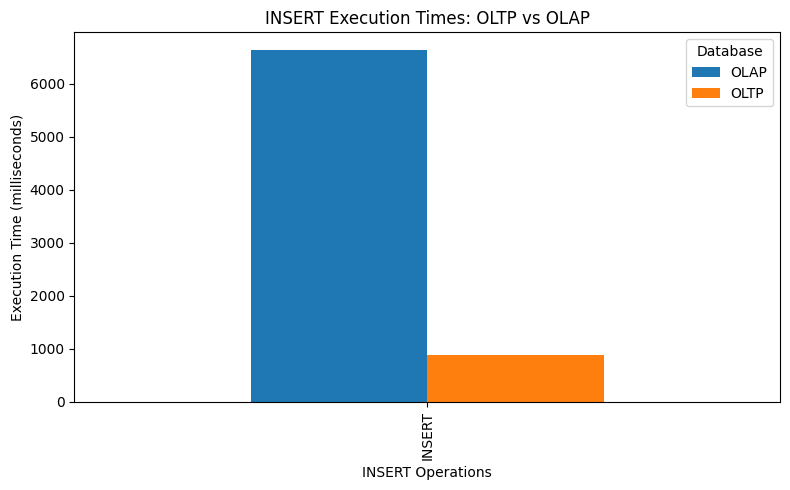

In [38]:
# Plot for INSERT operation
plt.figure(figsize=(8, 5))
insert_df.pivot(index='Operation', columns='Database', values='Execution Time (milliseconds)').plot(kind='bar', ax=plt.gca())
plt.title('INSERT Execution Times: OLTP vs OLAP')
plt.ylabel('Execution Time (milliseconds)')
plt.xlabel(xlabel="INSERT Operations")
plt.legend(title='Database')
plt.tight_layout()
plt.show()

Size of both databases

In [ ]:
size_query = "SELECT pg_size_pretty(pg_database_size(%s));"

cursor.execute(size_query, (DB_NAME,))
oltp_size = cursor.fetchone()

In [41]:
olap_size = conn_olap.execute("PRAGMA database_size;").fetchone()

In [45]:
print(f"OLTP Database Size: {oltp_size[0]}")
print(f"OLAP Database Size: {olap_size[1]}")

OLTP Database Size: 707 MB
OLAP Database Size: 23.5 MiB


# Final Observations

The OLAP database is optimized for read-heavy operations and complex queries, making it significantly faster for analytical workloads compared to the OLTP database. In contrast, the OLTP database is designed for high transaction throughput and quick insertions, which may lead to slower performance for complex queries due to its normalization and indexing strategies.

# Time DataFrame for select queries

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>Execution Time (milliseconds)</th>
    </tr>
    <tr>
      <th>Query</th>
      <th>Database</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">Query 1</th>
      <th>OLAP</th>
      <td>14.82</td>
    </tr>
    <tr>
      <th>OLTP</th>
      <td>246.23</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">Query 2</th>
      <th>OLAP</th>
      <td>60.99</td>
    </tr>
    <tr>
      <th>OLTP</th>
      <td>1801.17</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">Query 3</th>
      <th>OLAP</th>
      <td>18.81</td>
    </tr>
    <tr>
      <th>OLTP</th>
      <td>274.89</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">Query 4</th>
      <th>OLAP</th>
      <td>21.16</td>
    </tr>
    <tr>
      <th>OLTP</th>
      <td>136.92</td>
    </tr>
  </tbody>
</table>
</div>

# Time DataFrame for insert queries
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Operation</th>
      <th>Database</th>
      <th>Execution Time (milliseconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>INSERT</td>
      <td>OLTP</td>
      <td>874.34</td>
    </tr>
    <tr>
      <th>1</th>
      <td>INSERT</td>
      <td>OLAP</td>
      <td>6636.59</td>
    </tr>
  </tbody>
</table>
</div>

# Database Sizes

- OLTP Database Size: 707 MB
- OLAP Database Size: 23.5 MB
